# Set up

In [2]:
# import libraries 
import simfin as sf
import datetime
import random as rd
import numpy as np
import pandas as pd
import seaborn as seabornInstance 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

#set the local directory where data-files are stored
#change to your own directory
sf.set_data_dir('C:/Users/think/Desktop/UVA/2020Spring/STAT_4996_Capstone/simfin_data')

# 一个cell显示所有output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Set up API key
sf.set_api_key(api_key='free')

#display all columns
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
%qtconsole

# Define Function

In [4]:
#calculate the proportion of non-missing value in each column
def prop_nonmissing(df):
    df2 = df.reset_index().copy()
    output = pd.DataFrame(index = df2.columns)
    nomiss_prop = []
    for c in df2.columns:
        nomiss_prop.append(round((1-(df2.loc[:,c].isnull().sum()/len(df2.loc[:,c])))*100,2))
    output['Prop'] = nomiss_prop
    return output

# Load in data 

In [5]:
#load in entire annual income statement data
df_income_a = sf.load_income(variant='annual', market='us').reset_index()
#load in entire annual balance sheet data 
df_balance_a = sf.load_balance(variant='annual', market='us').reset_index()
#load in entire annual balance sheet data 
df_cashflow_a = sf.load_cashflow(variant='annual', market='us').reset_index()
#load in companies detail
comp = sf.load_companies(market='us').reset_index()
industry = sf.load_industries().reset_index()

Dataset "us-income-annual" on disk (34 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-annual" on disk (34 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (34 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-companies" on disk (26 days old).
- Loading from disk ... Done!
Dataset "industries" on disk (34 days old).
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!


# Merging Dtat

In [6]:
comp.head(2)
industry.head(2)
comp.shape
industry.shape

,Ticker,SimFinId,Company Name,IndustryId
0,A,45846,AGILENT TECHNOLOGIES INC,106001.0
1,AA,367153,Alcoa Corp,110004.0


,IndustryId,Sector,Industry
0,100001,Industrials,Industrial Products
1,100002,Industrials,Business Services


(2067, 4)

(71, 3)

In [7]:
len(set(df_cashflow_a['Ticker']) & set(df_income_a['Ticker']))
len(set(df_cashflow_a['Ticker']) & set(df_balance_a['Ticker']))
#三个表cover的公司完全相同

1924

1924

In [8]:
#left join industry on company
comp['IndustryId'] = comp[['IndustryId']].astype('float')
df = pd.merge(comp, industry, on ='IndustryId', how = 'left',suffixes=('','_right'))
df.head(5)
df.shape

,Ticker,SimFinId,Company Name,IndustryId,Sector,Industry
0,A,45846,AGILENT TECHNOLOGIES INC,106001.0,Healthcare,Medical Diagnostics & Research
1,AA,367153,Alcoa Corp,110004.0,Basic Materials,Metals & Mining
2,AAC,939324,"AAC Holdings, Inc.",NaN,NaN,NaN
3,AAL,68568,American Airlines Group Inc.,100006.0,Industrials,Airlines
4,AAME,450021,ATLANTIC AMERICAN CORP,104004.0,Financial Services,Insurance - Life


(2067, 6)

In [9]:
#left join income statement on previous df 
df2 = pd.merge(df,df_income_a,on = ['Ticker','SimFinId'], how = 'right')

'''
#check if joined properly: missing value percentage match
prop_nonmissing(df2).sort_values(by = 'Prop',ascending = False)
df2.head(2)
df2.columns
df2.shape
'''

"\n#check if joined properly: missing value percentage match\nprop_nonmissing(df2).sort_values(by = 'Prop',ascending = False)\ndf2.head(2)\ndf2.columns\ndf2.shape\n"

In [10]:
#left join balance sheet on previous df 
df_balance_a.shape
df3 = pd.merge(df2,df_balance_a,on = ['Ticker','SimFinId','Fiscal Year','Currency'], how = 'left', suffixes=('','_b'))

'''
#take a look at the merge data
df3.head(2)
df3.columns
#check if merge successfully, if successful, the row number should not change
df2.shape
df3.shape
prop_nonmissing(df3.iloc[:,~df3.columns.isin(df2.columns)]).sort_values(by = 'Prop', ascending = False)
'''

(14953, 29)

"\n#take a look at the merge data\ndf3.head(2)\ndf3.columns\n#check if merge successfully, if successful, the row number should not change\ndf2.shape\ndf3.shape\nprop_nonmissing(df3.iloc[:,~df3.columns.isin(df2.columns)]).sort_values(by = 'Prop', ascending = False)\n"

In [11]:
#left join balance sheet on previous df 
df_cashflow_a.shape
df4 = pd.merge(df3,df_cashflow_a,on = ['Ticker','SimFinId','Fiscal Year','Currency'], how = 'left', suffixes=('','_c'))

'''
#take a look at the merge data
df4.head(2)
df4.columns
#check if merge successfully, if successful, the row number should not change
df3.shape
df4.shape
prop_nonmissing(df4.iloc[:,~df4.columns.isin(df3.columns)]).sort_values(by = 'Prop', ascending = False)
'''

(14953, 27)

"\n#take a look at the merge data\ndf4.head(2)\ndf4.columns\n#check if merge successfully, if successful, the row number should not change\ndf3.shape\ndf4.shape\nprop_nonmissing(df4.iloc[:,~df4.columns.isin(df3.columns)]).sort_values(by = 'Prop', ascending = False)\n"

In [12]:
#delete old dataframe
del df3
del df2
del df
del df_balance_a
del df_cashflow_a
del df_income_a

In [13]:
#check overlapping columns 
df4.filter(regex='_').head()
df4[['Report Date','Fiscal Period','Publish Date','Shares (Basic)','Shares (Diluted)','Depreciation & Amortization']].head()
#check if we can delete any overlapping column 
#can delete report date_b and _c
#can delete depreciation & amortizaton 
sum((df4['Report Date_b'] == df4['Report Date_c'])== False)
sum((df4['Publish Date_b'] == df4['Publish Date_c'])== False)
sum((df4['Shares (Basic)_c'] == df4['Shares (Basic)'])== False)
sum((df4['Depreciation & Amortization'] == df4['Depreciation & Amortization_c'])== False)


,Report Date_b,Fiscal Period_b,Publish Date_b,Shares (Basic)_b,Shares (Diluted)_b,Report Date_c,Fiscal Period_c,Publish Date_c,Shares (Basic)_c,Shares (Diluted)_c,Depreciation & Amortization_c
0,2008-10-31,Q4,2009-10-05,357000000.0,359000000.0,2008-10-31,FY,2009-10-05,363000000.0,371000000.0,201000000.0
1,2009-10-31,Q4,2009-12-21,343000000.0,343000000.0,2009-10-31,FY,2009-12-21,346000000.0,346000000.0,162000000.0
2,2010-10-31,Q4,2010-12-20,344000000.0,356000000.0,2010-10-31,FY,2010-12-20,347000000.0,353000000.0,202000000.0
3,2011-10-31,Q4,2011-12-16,346000000.0,353000000.0,2011-10-31,FY,2011-12-16,347000000.0,355000000.0,253000000.0
4,2012-10-31,Q4,2012-12-20,348000000.0,353000000.0,2012-10-31,FY,2012-12-20,348000000.0,353000000.0,301000000.0


,Report Date,Fiscal Period,Publish Date,Shares (Basic),Shares (Diluted),Depreciation & Amortization
0,2008-10-31,FY,2009-10-05,363000000.0,371000000.0,NaN
1,2009-10-31,FY,2009-12-21,346000000.0,346000000.0,NaN
2,2010-10-31,FY,2010-12-20,347000000.0,353000000.0,NaN
3,2011-10-31,FY,2011-12-16,347000000.0,355000000.0,NaN
4,2012-10-31,FY,2012-12-20,348000000.0,353000000.0,NaN


0

438

95

14948

In [14]:
#rearrange data frame
#drop useless columns 
df4.drop(columns=['Report Date_b','Report Date_c','Depreciation & Amortization'],inplace=True)
df4.columns

Index(['Ticker', 'SimFinId', 'Company Name', 'IndustryId', 'Sector',
       'Industry', 'Report Date', 'Currency', 'Fiscal Year', 'Fiscal Period',
       'Publish Date', 'Shares (Basic)', 'Shares (Diluted)', 'Revenue',
       'Cost of Revenue', 'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Research & Development',
       'Operating Income (Loss)', 'Non-Operating Income (Loss)',
       'Interest Expense, Net', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Fiscal Period_b', 'Publish Date_b', 'Shares (Basic)_b',
       'Shares (Diluted)_b', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Inves

In [15]:
df4.rename(columns={"Depreciation & Amortization_c": "Depreciation & Amortization"},inplace=True)
df4.columns

Index(['Ticker', 'SimFinId', 'Company Name', 'IndustryId', 'Sector',
       'Industry', 'Report Date', 'Currency', 'Fiscal Year', 'Fiscal Period',
       'Publish Date', 'Shares (Basic)', 'Shares (Diluted)', 'Revenue',
       'Cost of Revenue', 'Gross Profit', 'Operating Expenses',
       'Selling, General & Administrative', 'Research & Development',
       'Operating Income (Loss)', 'Non-Operating Income (Loss)',
       'Interest Expense, Net', 'Pretax Income (Loss), Adj.',
       'Abnormal Gains (Losses)', 'Pretax Income (Loss)',
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations',
       'Net Extraordinary Gains (Losses)', 'Net Income', 'Net Income (Common)',
       'Fiscal Period_b', 'Publish Date_b', 'Shares (Basic)_b',
       'Shares (Diluted)_b', 'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
       'Property, Plant & Equipment, Net',
       'Long Term Inves

# Filling Missing Value

## Preparation Work 

以下所有的formula已全部替换为表内对应字段名
注意
1. Stock Price 目前没有对应字段
2. 有一些标注（year-start)的字段，对应的字段名内没有“(year-start)”


| Liquidity Ratios     | Formula |
| :---- | :---- |
| Current ratio |  Total Current Assets/Total Current Liabilities       |
| Quick ratio | (Cash, Cash Equivalents & Short Term Investments+ Accounts & Notes Receivable)/Total Current Liabilities|
|Net working capital to assets ratio| (Total Current Assets-Total Current Liabilities)/Total Current Assets|
|Cash ratio| Cash, Cash Equivalents & Short Term Investments/Total Current Liabilities|


| Leverage Ratios     | Formula |
| :---- | :---- |
| Long-term debt ratio |  Long Term Debt/(Long Term Debt+ Total Equity) |
| Liabilities to Equity Ratio|Total Liabilities/ Total Equity)|
|Total Debt ratio|Total Liabilities/Total Assets|
| Debt to Assets Ratio|(Long Term Debt+Short Term Debt)/Total Assets|
|Interest coverage ratio|Operating Income (Loss)/Interest Expense, Net|
|Cash coverage ratio|(Operating Income (Loss)+Depreciation & Amortization)/Interest Expense, Net|


| Profitability Ratios     | Formula |
| :---- | :---- |
|After Tax Operating Income|Revenue-Operating Expenses-Depreciation & Amortization-Income Tax (Expense) Benefit, Net|
| Return on Asset |After Tax Operating Income/Total Assets  |
| Return on Capital|After Tax Operating Income/(Long Term Debt+ Total Equity)|
| Return on Equity| After Tax Operating Income/Total Equity|
| Economic Value Added| After Tax Operating Income-Cost of capital（need outside data）* (Long Term Debt+ Total Equity)|




| Efficiency Ratios     | Formula |
| :---- | :---- |
| Operating profit margin| Operating Income (Loss)/Revenue|
|Net Profit Margin| Net Income (Common)/Revenue|
|Asset Turnover|Revenue/Total Assets(year-start)|
|Receivable turover|Revenue/Accounts & Notes Receivable(year-start)|
|Inventory turnover|Cost of Revenue/Inventories(year-start)|



| Performance Ratios     | Formula |
| :---- | :---- |
| Market Value added| Stock Price * Shares (Basic) -Total Equity|
| Market to Book ratio|Stock Price * Shares (Basic)/Total Equity|
|Earning per Share|Net Income (Common)/Shares (Basic)|
|Sales per Share|Revenue/Shares (Basic)|
|Price to Earning Ratio|Stock Price/Earning Per Share|
|Price to Book Ratio|Stock Price/(Total Equity/Shares (Basic))|



In [16]:
#选取所需的column
cols1 = ['Ticker', 'SimFinId', 'Company Name', 'IndustryId', 'Sector',
       'Industry', 'Report Date', 'Fiscal Year', 'Shares (Diluted)',
        'Revenue','Cost of Revenue',  'Operating Expenses',
       'Operating Income (Loss)', 'Interest Expense, Net', 
       'Income Tax (Expense) Benefit, Net',
       'Income (Loss) from Continuing Operations', 'Net Income (Common)',
       'Cash, Cash Equivalents & Short Term Investments',
       'Accounts & Notes Receivable', 'Inventories', 'Total Current Assets',
        'Total Assets',  'Total Current Liabilities', 'Long Term Debt',
        'Total Liabilities', 'Total Equity', 
       'Fiscal Period_c', 'Publish Date_c', 'Net Income/Starting Line',
       'Depreciation & Amortization', 'Net Cash from Operating Activities',
        'Dividends Paid']
#columns used to calculate missing values
cols2 = [ "Pretax Income (Loss), Adj.",'Total Liabilities & Equity']
#drop rows where Industry is missing
df = df4[cols1+cols2][df4['Industry'].notnull()]
#fill dividend with 0 
df['Dividends Paid'] = df['Dividends Paid'].fillna(0)
prop_nonmissing(df).sort_values(by='Prop', ascending = False)
df.shape

,Prop
index,100.00
Income (Loss) from Continuing Operations,100.00
"Pretax Income (Loss), Adj.",100.00
Dividends Paid,100.00
Net Cash from Operating Activities,100.00
Publish Date_c,100.00
Fiscal Period_c,100.00
Total Liabilities,100.00
Total Current Liabilities,100.00
Total Assets,100.00


(13992, 34)

In [30]:
#导出数据，以下的分析在R中进行
dropcol = ['Currency',  'Shares (Basic)', 'Net Income', 
       'Fiscal Period_b', 'Publish Date_b', 'Shares (Basic)_b',
       'Shares (Diluted)_b',
       'Fiscal Period_c', 'Publish Date_c', 'Shares (Basic)_c',
       'Shares (Diluted)_c', 'Net Income/Starting Line']
df = df4[df4.Industry.notnull()].drop(labels = dropcol, axis = 1)
df['Dividends Paid'] = df['Dividends Paid'].fillna(0)
prop_nonmissing(df).sort_values(by='Prop', ascending = False)
df.shape
df.to_csv('C:/Users/think/Desktop/UVA/2020Spring/STAT_4996_Capstone/capstone_repository/data/df.csv', index = False, header=True)

,Prop
index,100.00
"Pretax Income (Loss), Adj.",100.00
Dividends Paid,100.00
Net Cash from Operating Activities,100.00
Total Liabilities & Equity,100.00
Total Liabilities,100.00
Total Current Liabilities,100.00
Total Assets,100.00
Ticker,100.00
Net Income (Common),100.00


(13992, 64)

In [16]:
#count the number of rows with no missing values. 
df.notnull().all(axis=1).sum() #6676行没missing value
#count the number of companies with no missing value
df[df.notnull().all(axis=1)]['Ticker'].nunique() #954个公司完全没有missing value

6676

954

In [ ]:
#assign columns to three members 
random.seed(4996)
rand = random.sample(['Yimeng','Zhenzhen','Xinru']*5, 15)
assign = {'ratios': df.columns[df.isnull().any()], 'assignment': rand}
pd.DataFrame(assign)

## Finding Correlations

In [160]:
'''prop_nonmissing(df[df['Sector']== 'Technology']).sort_values(by = 'Prop', ascending = False)
corr2 = df4[df4['Sector'] == 'Technology'].corr()
abs(corr2[['Inventories']])[abs(corr2['Inventories'])>0.7].sort_values(by = 'Inventories', ascending = False )'''

,Prop
index,100.00
Income (Loss) from Continuing Operations,100.00
Total Liabilities & Equity,100.00
"Pretax Income (Loss), Adj.",100.00
Dividends Paid,100.00
Net Cash from Operating Activities,100.00
Publish Date_c,100.00
Fiscal Period_c,100.00
Total Equity,100.00
Total Liabilities,100.00


,Inventories
Inventories,1.000000
Cost of Revenue,0.711034


### Operating Income

In [124]:
#find the columns that has correlation with Operating Income larger than 0.7
corr = df4.corr()
abs(corr[['Operating Income (Loss)']])[abs(corr['Operating Income (Loss)']) > 0.8].sort_values(by = 'Operating Income (Loss)', ascending = False )
#get those columns' names
names = abs(corr[['Operating Income (Loss)']])[abs(corr['Operating Income (Loss)']) > 0.8].sort_values(by = 'Operating Income (Loss)', ascending = False ).index.values.tolist()

#Pretax Income(Loss) has the highest correlation
#check if it has missing value in rows where Operating Income is null: 100% non-missing
df4[df4['Operating Income (Loss)'].isnull()]['Pretax Income (Loss), Adj.'].isnull().any()

,Operating Income (Loss)
Operating Income (Loss),1.000000
"Pretax Income (Loss), Adj.",0.947483
Pretax Income (Loss),0.920440
Gross Profit,0.873886
Net Cash from Operating Activities,0.869203
Income (Loss) from Continuing Operations,0.865969
Net Income/Starting Line,0.857612
Net Income,0.854496
Net Income (Common),0.854224
"Income Tax (Expense) Benefit, Net",0.816792


False

Text(0.5, 0, 'Pretax Income (Loss), Adj.')

Text(0, 0.5, 'Operating Income (Loss)')

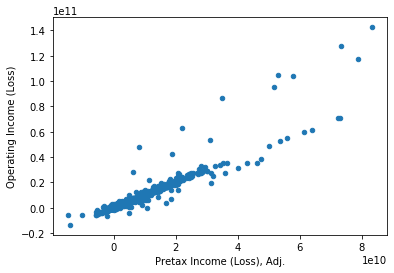

In [125]:
#check the linearity: pretty linear  
mydata = df4[["Operating Income (Loss)", "Pretax Income (Loss), Adj."]].dropna(how="any")
mydata.plot(kind= 'scatter', x="Pretax Income (Loss), Adj.", y="Operating Income (Loss)")
plt.xlabel("Pretax Income (Loss), Adj.")
plt.ylabel("Operating Income (Loss)")
plt.show()

In [126]:
#fit linear regression and use the fitted value to fill missing value
regressor = LinearRegression()  
train = df[["Pretax Income (Loss), Adj.","Operating Income (Loss)" ]][df["Operating Income (Loss)" ].notnull()]
regressor.fit(train.iloc[:,0].values.reshape(-1,1), train.iloc[:,1].values.reshape(-1,1)) #training the algorithm
predict1 =  regressor.predict(df["Pretax Income (Loss), Adj."].values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

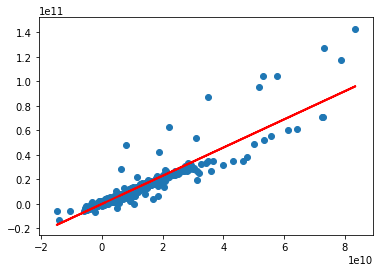

In [127]:
#check result 
plt.plot(df["Pretax Income (Loss), Adj."].values.reshape(-1,1), predict1, color='red', linewidth=2)
plt.scatter(mydata["Pretax Income (Loss), Adj."], mydata["Operating Income (Loss)"])
plt.show()

In [128]:
#assign fitted value to missing value
df.loc[df["Operating Income (Loss)"].isnull(),"Operating Income (Loss)"]=list(predict1.reshape(-1)[np.array(df["Operating Income (Loss)"].isnull())])

### Total current asset

In [129]:
#find the columns that has correlation with Operating Income larger than 0.8
abs(corr[['Total Current Assets']])[abs(corr['Total Current Assets']) > 0.8].sort_values(by = 'Total Current Assets', ascending = False )
#get those columns' names
names = abs(corr[['Total Current Assets']])[abs(corr['Total Current Assets']) > 0.8].index.values.tolist()

#check whether these column have missing value when total current asset is null
prop_nonmissing(df4[df4['Total Current Assets'].isnull()][names])
#total liabilities have the best performance, lets check for linearity

,Total Current Assets
Total Current Assets,1.000000
Research & Development,0.837776
Total Liabilities,0.810185
Total Current Liabilities,0.809414
Total Assets,0.801755
Total Liabilities & Equity,0.801754


,Prop
index,100.0
Research & Development,0.0
Total Current Assets,0.0
Total Assets,100.0
Total Current Liabilities,100.0
Total Liabilities,100.0
Total Liabilities & Equity,100.0


In [130]:
#check the linearity: pretty linear  
mydata = df4[['Total Current Assets', "Total Liabilities" ]].dropna(how="any")

Text(0.5, 0, 'Total Liabilities')

Text(0, 0.5, 'Total Current Assets')

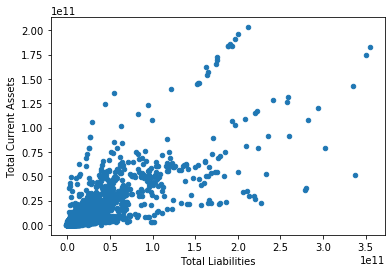

In [131]:
mydata.plot(kind= 'scatter', x="Total Liabilities", y='Total Current Assets')
plt.xlabel("Total Liabilities")
plt.ylabel('Total Current Assets')

In [132]:
#fit linear regression and use the fitted value to fill missing value
regressor = LinearRegression()  
train = df[["Total Liabilities",'Total Current Assets']][df['Total Current Assets'].notnull()]
regressor.fit(train.iloc[:,0].values.reshape(-1,1), train.iloc[:,1].values.reshape(-1,1)) #training the algorithm
predict =  regressor.predict(df["Total Liabilities"].values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

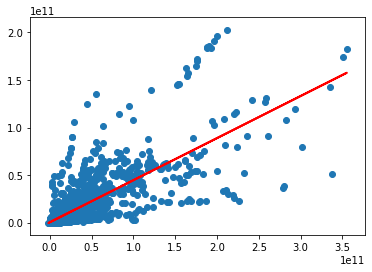

In [70]:
#check result 
plt.plot(df["Total Liabilities"].values.reshape(-1,1), predict, color='red', linewidth=2)
plt.scatter(mydata["Total Liabilities"], mydata['Total Current Assets'])
plt.show()

In [133]:
#assign fitted value to missing value
df.loc[df['Total Current Assets'].isnull(),'Total Current Assets']=list(predict.reshape(-1)[np.array(df['Total Current Assets'].isnull())])

#### log transformation

In [79]:
#只是试试没有拿他fill
mydata_log = mydata.copy()
mydata_log.shape
mydata_log.describe()

(14763, 2)

,Total Current Assets,Total Liabilities
count,1.476300e+04,1.476300e+04
mean,3.267329e+09,6.587913e+09
std,1.057781e+10,1.937553e+10
min,0.000000e+00,-1.742919e+09
25%,1.452025e+08,1.155585e+08
50%,5.855040e+08,9.734850e+08
75%,2.216942e+09,4.690600e+09
max,2.030620e+11,3.552940e+11


In [80]:
mydata_log = mydata_log[(mydata_log> 0).all(1)]
mydata_log = np.log2(mydata_log)
mydata_log.describe()
mydata_log.shape

,Total Current Assets,Total Liabilities
count,14736.000000,14736.000000
mean,28.874116,29.342413
std,3.297359,3.800551
min,7.882643,8.965784
25%,27.121027,26.801119
50%,29.132212,29.864946
75%,31.048514,32.131133
max,37.563129,38.370222


(14736, 2)

Text(0.5, 0, 'Total Liabilities')

Text(0, 0.5, 'Total Current Assets')

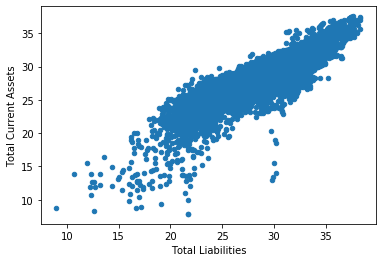

In [81]:
mydata_log.plot(kind= 'scatter', x="Total Liabilities", y='Total Current Assets')
plt.xlabel("Total Liabilities")
plt.ylabel('Total Current Assets')

In [100]:
#fit linear regression and use the fitted value to fill missing value
regressor = LinearRegression()  
train = df[["Total Liabilities",'Total Current Assets']][df['Total Current Assets'].notnull()]
train = train[(train > 0).all(1)]
train = np.log2(train)
train.shape
train.describe()

(13895, 2)

,Total Liabilities,Total Current Assets
count,13895.000000,13895.000000
mean,29.547698,29.103546
std,3.636779,2.983452
min,12.374768,7.882643
25%,27.023897,27.294652
50%,30.031027,29.274754
75%,32.223450,31.111690
max,38.370222,37.563129


In [101]:
regressor.fit(train.iloc[:,0].values.reshape(-1,1), train.iloc[:,1].values.reshape(-1,1)) #training the algorithm
predict =  regressor.predict(np.log2(df["Total Liabilities"][df["Total Liabilities"]>0]).values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

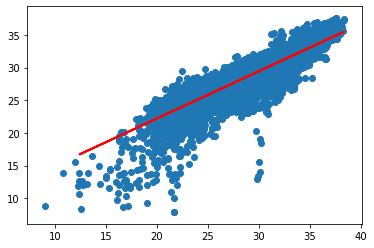

In [95]:
#check result 
plt.plot(np.log2(df["Total Liabilities"][df["Total Liabilities"]>0]).values.reshape(-1,1), predict, color='red', linewidth=2)
plt.scatter(mydata_log["Total Liabilities"], mydata_log['Total Current Assets'])
plt.show()

### Total Equity

In [134]:
#we can use formula to fill 
prop_nonmissing(df4[df4['Total Equity'].isnull()][['Total Liabilities', 'Total Liabilities & Equity']])
df[df['Total Equity'].isnull()]

,Prop
index,100.0
Total Liabilities,100.0
Total Liabilities & Equity,100.0


,Ticker,SimFinId,Company Name,IndustryId,Sector,Industry,Report Date,Fiscal Year,Shares (Diluted),Revenue,Cost of Revenue,Operating Expenses,Operating Income (Loss),"Interest Expense, Net","Income Tax (Expense) Benefit, Net",Income (Loss) from Continuing Operations,Net Income (Common),"Cash, Cash Equivalents & Short Term Investments",Accounts & Notes Receivable,Inventories,Total Current Assets,Total Assets,Total Current Liabilities,Long Term Debt,Total Liabilities,Total Equity,Fiscal Period_c,Publish Date_c,Net Income/Starting Line,Depreciation & Amortization,Net Cash from Operating Activities,Dividends Paid,"Pretax Income (Loss), Adj.",Total Liabilities & Equity
3165,CNNX,208611,CONE Midstream Partners LP,107003.0,Energy,Oil & Gas - Midstream,2013-12-31,2013,NaN,65626000.0,-16669000.0,-20833000.0,28124000.0,0.0,NaN,28124000,28124000,5976000.0,NaN,NaN,21148000.0,409264000,41190000,368074000.0,409264000,NaN,FY,2014-10-30,28124000.0,5825000.0,34514000,0.0,28124000,409264000


In [135]:
#这个公司不存在equity，用0fill
df.loc[df['Total Equity'].isnull(),'Total Equity'] = 0

In [136]:
prop_nonmissing(df).sort_values(by = 'Prop', ascending = False)
df.shape

,Prop
index,100.00
Income (Loss) from Continuing Operations,100.00
"Pretax Income (Loss), Adj.",100.00
Dividends Paid,100.00
Net Cash from Operating Activities,100.00
Publish Date_c,100.00
Fiscal Period_c,100.00
Total Equity,100.00
Total Liabilities,100.00
Total Current Liabilities,100.00


(13913, 34)

### Net Income/Starting Line	

In [141]:
#属于cash flow statement，与net income值很不一样
df4['Net Income/Starting Line'] == df4['Net Income (Common)'].sum()/len(df4)
df4[df4['Net Income/Starting Line'] != df4['Net Income (Common)']][['Net Income (Common)','Net Income/Starting Line','Net Income']].head()
#属于Cash Flow Statement 下方，计算还是用Net Income(Common)因为我们关心有多少net income可以distribute给shareholders
df = df.drop('Net Income/Starting Line', axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
14763    False
14764    False
14765    False
14766    False
14767    False
Name: Net Income/Starting Line, Length: 14768, dtype: bool

,Net Income (Common),Net Income/Starting Line,Net Income
11,-863000000,-739000000.0,-863000000
12,-400000000,-346000000.0,-400000000
13,217000000,559000000.0,217000000
14,227000000,871000000.0,227000000
15,-21218000,-26370000.0,-21218000


### Depreciation & Amortization

In [143]:
y = 'Depreciation & Amortization'
#find the columns that has correlation with Depreciation & Amortization larger than 0.8
abs(corr[[y]])[abs(corr[y]) > 0.8].sort_values(by = y, ascending = False )
#get those columns' names
names = abs(corr[[y]])[abs(corr[y]) > 0.8].index.values.tolist()

#check whether these column have missing value when total current asset is null
prop_nonmissing(df4[df4[y].isnull()][names]).sort_values(by = 'Prop',ascending = False)
#Total Liabilities & Equity have the best performance, lets check for linearity
x = 'Total Liabilities & Equity'

,Depreciation & Amortization
Depreciation & Amortization,1.000000
Total Noncurrent Assets,0.869823
Change in Fixed Assets & Intangibles,0.845656
Total Liabilities & Equity,0.839665
Total Assets,0.839665
"Property, Plant & Equipment, Net",0.836715
Net Cash from Operating Activities,0.831898
Gross Profit,0.828472
Total Noncurrent Liabilities,0.819441
Operating Expenses,0.808842


,Prop
index,100.00
Total Assets,100.00
Total Liabilities & Equity,100.00
Net Cash from Operating Activities,100.00
Operating Expenses,98.71
Gross Profit,92.23
Total Noncurrent Liabilities,89.32
Total Noncurrent Assets,81.88
Change in Fixed Assets & Intangibles,62.14
"Property, Plant & Equipment, Net",58.25


Text(0.5, 0, 'Total Liabilities & Equity')

Text(0, 0.5, 'Depreciation & Amortization')

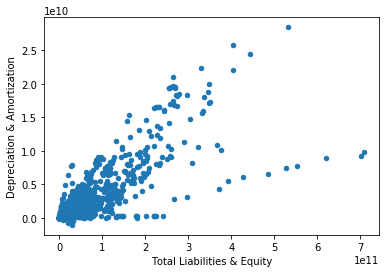

In [144]:
#check the linearity: pretty linear  
mydata = df4[[x, y]].dropna(how="any")
mydata.plot(kind= 'scatter', x=x, y=y)
plt.xlabel("Total Liabilities & Equity")
plt.ylabel('Depreciation & Amortization')

In [145]:
# Number of data point missing 
df[y].isnull().sum()

232

In [146]:
#fit linear regression and use the fitted value to fill missing value
regressor = LinearRegression()  
train = df[[x,y]][df[y].notnull()]
regressor.fit(train.iloc[:,0].values.reshape(-1,1), train.iloc[:,1].values.reshape(-1,1)) #training the algorithm
predict =  regressor.predict(df[x].values.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

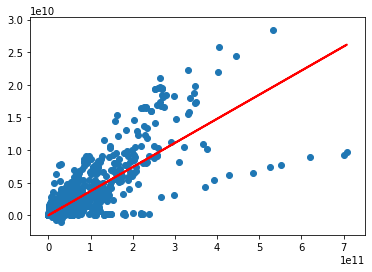

In [147]:
#check result 
plt.plot(df[x].values.reshape(-1,1), predict, color='red', linewidth=2)
plt.scatter(mydata[x], mydata[y])
plt.show()

In [ ]:
#assign fitted value to missing value
df.loc[df[y].isnull(),y]=list(predict.reshape(-1)[np.array(df[y].isnull())])

In [150]:
df.loc[df[y].isnull(),'Depre_fill']=df[y].isnull()

In [151]:
prop_nonmissing(df)

,Prop
index,100.00
Ticker,100.00
SimFinId,100.00
Company Name,100.00
IndustryId,100.00
Sector,100.00
Industry,100.00
Report Date,100.00
Fiscal Year,100.00
Shares (Diluted),97.21
